# Pathogen Removal in Bank Filtration Systems

## Learning Objectives
- Understand log-removal concepts for pathogen treatment assessment
- Calculate pathogen removal efficiency in groundwater treatment systems
- Learn how heterogeneous systems affect overall performance
- Apply residence time analysis to water treatment design
- Analyze seasonal variations in treatment performance

## Overview

This notebook demonstrates how to calculate pathogen removal efficiency in groundwater treatment systems using log-removal analysis. Understanding pathogen removal is crucial for safe drinking water production from riverbank filtration and managed aquifer recharge systems.

### Real-World Context
Bank filtration is widely used in Europe for drinking water treatment. River water infiltrates through riverbank sediments, where pathogens are naturally filtered out through physical straining and biological decay. The longer water stays underground, the more pathogens are removed.

### Applications
- Drinking water treatment design
- Bank filtration system optimization
- Risk assessment for water supplies
- Regulatory compliance evaluation
- Treatment performance monitoring

### Key Concepts
- **Log-removal**: Logarithmic scale for pathogen reduction
- **Residence time dependency**: Longer contact time = better removal
- **Heterogeneous systems**: Multiple flow paths with different performance
- **Design standards**: WHO/EPA guidelines for pathogen removal

## Theoretical Background

### Log-Removal Fundamentals

Log-removal quantifies pathogen reduction on a logarithmic scale:

$$\text{Log-removal} = \log_{10}\left(\frac{C_{in}}{C_{out}}\right)$$

Where:
- $C_{in}$: Input pathogen concentration
- $C_{out}$: Output pathogen concentration

**Practical Interpretation**:
- 1 log10 = 90% removal (1 in 10 pathogens remain)
- 2 log10 = 99% removal (1 in 100 pathogens remain)  
- 3 log10 = 99.9% removal (1 in 1000 pathogens remain)

### Residence Time Relationship

Log-removal depends on residence time through first-order decay:

$$\text{Log-removal} = k \cdot \log_{10}(t_{residence})$$

Where:
- $k$: Removal rate constant [log10/log10(day)] - depends on pathogen type and aquifer properties
- $t_{residence}$: Residence time [days]

### Heterogeneous Systems

For systems with multiple flow paths, the overall log-removal is weighted toward lower values (shorter residence times), providing natural safety margins in design.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from gwtransport import gamma as gamma_utils
from gwtransport.examples import generate_example_data
from gwtransport.logremoval import (
    gamma_find_flow_for_target_mean,
    gamma_mean,
    parallel_mean,
    residence_time_to_log_removal,
)
from gwtransport.residence_time import residence_time

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Understanding Basic Log-Removal

We start with a simple example to illustrate the fundamental relationship between residence time and pathogen removal.

In [2]:
print("=== Basic Log-Removal Calculation ===")
print("Simulating a small bank filtration system...\n")

# Define aquifer characteristics (small riverbank aquifer)
mean_pore_volume = 1000.0  # m³ (total water-filled space)
std_pore_volume = 300.0  # m³ (variability in pore volume)
flow_rate = 50.0  # m³/day (water extraction rate)
log_removal_rate = 3.5  # log10 removal per log10(day) (typical for bacteria)

# WHO standard for pathogen removal
WHO_STANDARD = 2.0  # log10 removal required

# Convert aquifer properties to gamma distribution parameters
alpha, beta = gamma_utils.mean_std_to_alpha_beta(mean_pore_volume, std_pore_volume)

# Calculate residence time statistics
rt_alpha = alpha
rt_beta = beta / flow_rate

# Calculate pathogen log-removal
mean_log_removal = gamma_mean(rt_alpha, rt_beta, log_removal_rate)
removal_efficiency = (1 - 10 ** (-mean_log_removal)) * 100

# Display results
mean_residence_time = mean_pore_volume / flow_rate

print("Aquifer Setup:")
print(f"  • Pore volume: {mean_pore_volume:.0f} ± {std_pore_volume:.0f} m³")
print(f"  • Flow rate: {flow_rate} m³/day")
print(f"  • Mean residence time: {mean_residence_time:.1f} days")
print(f"  • Removal rate constant: {log_removal_rate} log10/log10(day)")

print("\nPathogen Removal Results:")
print(f"  • Log-removal: {mean_log_removal:.2f} log10")
print(f"  • Removal efficiency: {removal_efficiency:.1f}%")
print(f"  • Remaining pathogens: {100 - removal_efficiency:.1f}%")

# Safety assessment
if mean_log_removal >= WHO_STANDARD:
    print(f"  ✅ Meets WHO standards (≥{WHO_STANDARD} log10 removal)")
else:
    print(f"  ❌ Does not meet WHO standards (≥{WHO_STANDARD} log10 removal)")

=== Basic Log-Removal Calculation ===
Simulating a small bank filtration system...

Aquifer Setup:
  • Pore volume: 1000 ± 300 m³
  • Flow rate: 50.0 m³/day
  • Mean residence time: 20.0 days
  • Removal rate constant: 3.5 log10/log10(day)

Pathogen Removal Results:
  • Log-removal: 4.48 log10
  • Removal efficiency: 100.0%
  • Remaining pathogens: 0.0%
  ✅ Meets WHO standards (≥2.0 log10 removal)


## 2. Heterogeneous System Performance

Bank filtration systems have multiple flow paths with different residence times. The overall log-removal is weighted toward lower values (shorter residence times) and provides natural safety margins.

In [3]:
print("=== Heterogeneous System Analysis ===")
print("Multiple flow paths with different residence times\n")

# Three flow paths with different log-removal efficiencies
unit_removals = np.array([0.5, 1.0, 1.5])  # log10 values for each path

# Correct method: parallel_mean() accounts for flow-weighted averaging
combined_removal = parallel_mean(unit_removals)

print("Flow Path Performance:")
for i, removal in enumerate(unit_removals):
    efficiency = (1 - 10 ** (-removal)) * 100
    print(f"  Path {i + 1}: {removal:.1f} log10 → {efficiency:.1f}% removal")

print("\nOverall System Performance:")
combined_efficiency = (1 - 10 ** (-combined_removal)) * 100
print(f"  Combined log-removal: {combined_removal:.2f} log10 → {combined_efficiency:.1f}% removal")

print("\n💡 Note: Overall performance is weighted toward the worst-performing paths")
print("   (shortest residence times), ensuring conservative design.")

=== Heterogeneous System Analysis ===
Multiple flow paths with different residence times

Flow Path Performance:
  Path 1: 0.5 log10 → 68.4% removal
  Path 2: 1.0 log10 → 90.0% removal
  Path 3: 1.5 log10 → 96.8% removal

Overall System Performance:
  Combined log-removal: 0.83 log10 → 85.1% removal

💡 Note: Overall performance is weighted toward the worst-performing paths
   (shortest residence times), ensuring conservative design.


## 3. Design Application - Meeting Safety Standards

Water treatment facilities must meet strict pathogen removal standards. We demonstrate how to design systems that achieve target removal efficiency.

In [4]:
print("=== Design Application ===")
print("Design challenge: Meet WHO standards for safe drinking water\n")

# WHO recommendation: minimum 2 log10 (99%) removal for bacteria
target_removal = 6.0
target_efficiency = (1 - 10 ** (-target_removal)) * 100

print(f"Target: {target_removal} log10 removal ({target_efficiency:.0f}% efficiency)")

# Find the maximum flow rate that still achieves our target
required_flow = gamma_find_flow_for_target_mean(
    target_mean=target_removal,
    apv_alpha=alpha,
    apv_beta=beta,
    log_removal_rate=log_removal_rate,
)

required_residence_time = mean_pore_volume / required_flow

print("\nDesign Solution:")
print(f"  • Maximum flow rate: {required_flow:.1f} m³/day")
print(f"  • Required residence time: {required_residence_time:.1f} days")
print(f"  • Daily water production: {required_flow:.1f} m³ = {required_flow * 1000:.0f} liters")

# Compare with original flow rate
flow_reduction = (1 - required_flow / flow_rate) * 100
print("\nComparison with original design:")
print(f"  • Flow reduction needed: {flow_reduction:.1f}%")
print(f"  • Production capacity: {required_flow / flow_rate * 100:.1f}% of original")

print("\n💡 Engineering Insight: Higher flow rates mean shorter residence times,")
print("   which reduces pathogen removal. There's always a trade-off between")
print("   water production capacity and treatment effectiveness.")

=== Design Application ===
Design challenge: Meet WHO standards for safe drinking water

Target: 6.0 log10 removal (100% efficiency)

Design Solution:
  • Maximum flow rate: 18.4 m³/day
  • Required residence time: 54.2 days
  • Daily water production: 18.4 m³ = 18445 liters

Comparison with original design:
  • Flow reduction needed: 63.1%
  • Production capacity: 36.9% of original

💡 Engineering Insight: Higher flow rates mean shorter residence times,
   which reduces pathogen removal. There's always a trade-off between
   water production capacity and treatment effectiveness.


## 4. Real-World Scenario - Seasonal Variations

In reality, river flows change seasonally, affecting bank filtration performance. We simulate a multi-year system to see how log-removal varies with changing conditions.

In [ ]:
print("=== Seasonal Flow Data Generation ===")

# Generate realistic flow data with seasonal patterns
df, tedges = generate_example_data(
    date_start="2020-01-01",
    date_end="2025-05-31",
    flow_mean=120.0,  # Base flow rate [m³/day]
    flow_amplitude=40.0,  # Seasonal flow variation [m³/day]
    flow_noise=5.0,  # Random daily fluctuations [m³/day]
    temp_infiltration_method="soil_temperature",  # Use real soil temperature data
    aquifer_pore_volume_gamma_mean=8000.0,  # True mean pore volume [m³]
    aquifer_pore_volume_gamma_std=400.0,  # True standard deviation [m³]
    retardation_factor=2.0,  # Thermal retardation factor [-]
)

# Set up aquifer characteristics for this larger system
bins = gamma_utils.bins(
    mean=df.attrs["aquifer_pore_volume_gamma_mean"], std=df.attrs["aquifer_pore_volume_gamma_std"], n_bins=1000
)  # High resolution

print(f"Dataset: {len(df)} days from {df.index[0].date()} to {df.index[-1].date()}")
print(f"Flow range: {df['flow'].min():.1f} - {df['flow'].max():.1f} m³/day")
print(f"Aquifer: {df.attrs['aquifer_pore_volume_gamma_mean']:.0f} ± {df.attrs['aquifer_pore_volume_gamma_std']:.0f} m³ pore volume")

=== Seasonal Flow Data Generation ===
Dataset: 1978 days from 2020-01-01 to 2025-05-31
Flow range: 8.1 - 170.0 m³/day
Aquifer: 8000 ± 400 m³ pore volume


In [6]:
print("\nComputing pathogen removal over time...")

# Calculate residence time distribution for water flow
rt_infiltration_to_extraction_water = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volume=bins["expected_value"],
    retardation_factor=1.0,  # Water (conservative tracer)
    direction="infiltration_to_extraction",
)

# Compute log-removal for each flow path and time point
log_removal_array = residence_time_to_log_removal(
    residence_times=rt_infiltration_to_extraction_water,
    log_removal_rate=log_removal_rate,
)

# Average across all flow paths (using correct parallel averaging)
df["log_removal"] = parallel_mean(log_removal_array, axis=0)
df["removal_efficiency"] = (1 - 10 ** (-df["log_removal"])) * 100

print("Time series calculation completed")
print(f"Log-removal range: {df['log_removal'].min():.2f} - {df['log_removal'].max():.2f} log10")
print(f"Efficiency range: {df['removal_efficiency'].min():.1f}% - {df['removal_efficiency'].max():.1f}%")


Computing pathogen removal over time...
Time series calculation completed
Log-removal range: 5.94 - 7.17 log10
Efficiency range: 100.0% - 100.0%


## 5. Performance Visualization

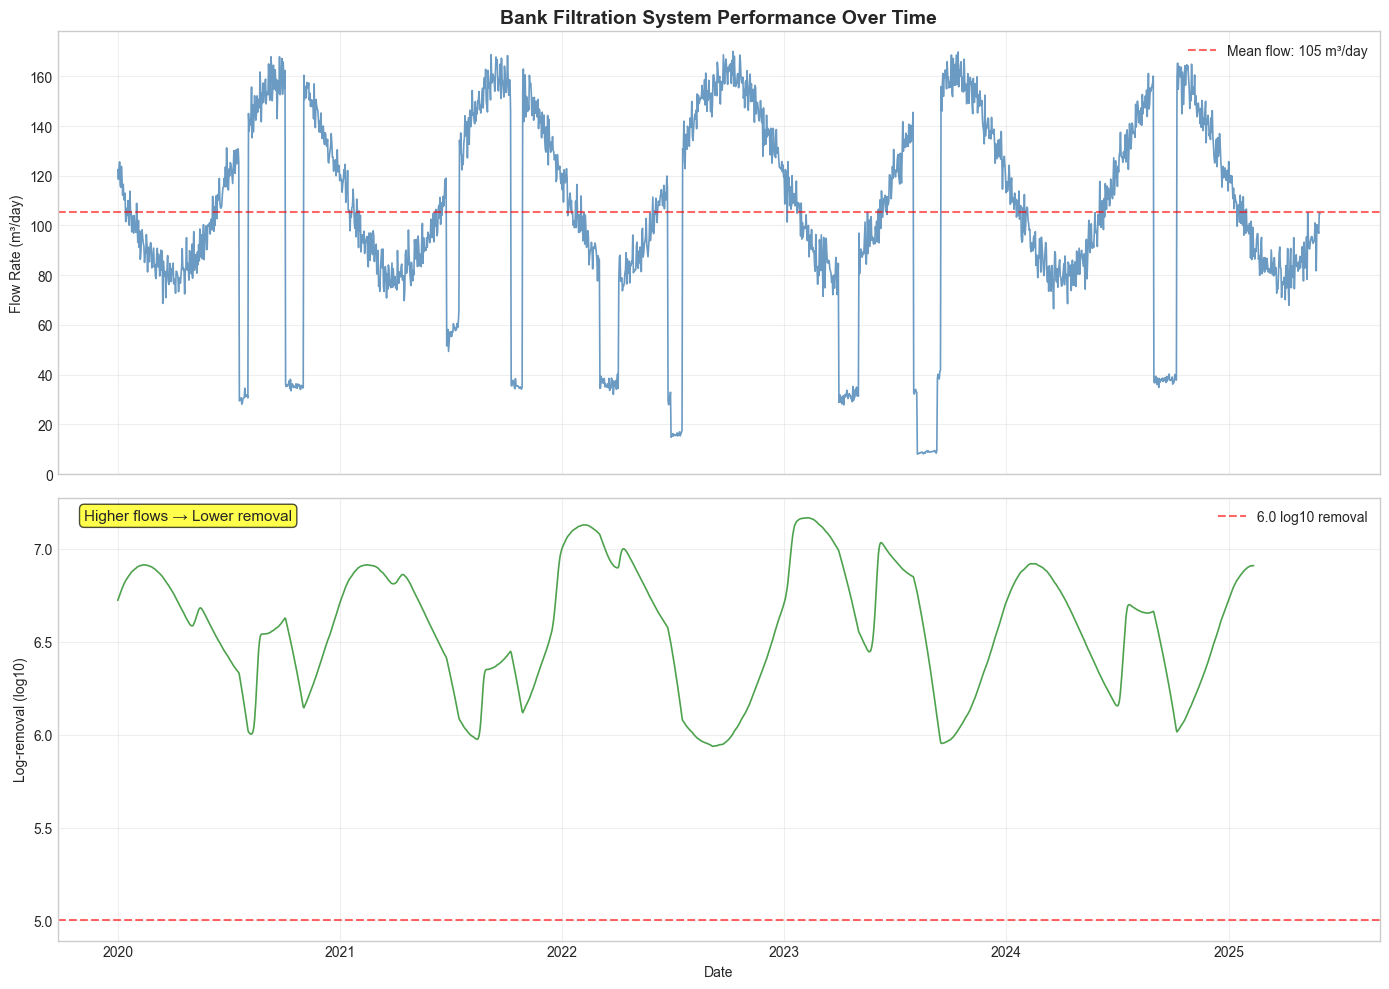

📈 Time series plot saved to: 03_log_removal_time_series.png


In [7]:
# Create informative time series plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Flow rate over time
ax1.plot(df.index, df.flow, color="steelblue", linewidth=1.2, alpha=0.8)
ax1.set_ylabel("Flow Rate (m³/day)")
ax1.set_title("Bank Filtration System Performance Over Time", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.axhline(
    y=df.flow.mean(),
    color="red",
    linestyle="--",
    alpha=0.6,
    label=f"Mean flow: {df.flow.mean():.0f} m³/day",
)
ax1.legend()

# Plot 2: Log-removal over time
ax2.plot(df.index, df.log_removal, color="forestgreen", linewidth=1.2, alpha=0.8)
ax2.set_ylabel("Log-removal (log10)")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.3)

# Add WHO standard line
ax2.axhline(y=5.0, color="red", linestyle="--", alpha=0.6, label=f"{target_removal} log10 removal")
ax2.legend()

# Add seasonal annotations
ax2.text(
    0.02,
    0.95,
    "Higher flows → Lower removal",
    transform=ax2.transAxes,
    fontsize=11,
    bbox={"boxstyle": "round,pad=0.3", "facecolor": "yellow", "alpha": 0.7},
)

plt.tight_layout()

# Save the time series plot
out_path = Path("03_log_removal_time_series.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"📈 Time series plot saved to: {out_path}")

## 6. Performance Summary and Analysis

In [8]:
# Calculate and display summary statistics
min_removal = df["log_removal"].min()
max_removal = df["log_removal"].max()
mean_removal = df["log_removal"].mean()
min_efficiency = df["removal_efficiency"].min()
max_efficiency = df["removal_efficiency"].max()
std_removal = df["log_removal"].std()

# WHO compliance analysis
WHO_STANDARD = 2.0  # log10 removal required
EXCELLENT_COMPLIANCE = 95  # percentage threshold
GOOD_COMPLIANCE = 90  # percentage threshold
STRONG_CORRELATION = -0.7  # correlation threshold
MODERATE_CORRELATION = -0.3  # correlation threshold

who_compliant_days = (df["log_removal"] >= WHO_STANDARD).sum()
who_compliance_percent = who_compliant_days / len(df) * 100

# Flow-removal correlation
flow_removal_corr = np.corrcoef(df["flow"], df["log_removal"])[0, 1]

print("📊 Performance Summary (6-year analysis):")
print("=" * 50)
print("Log-removal statistics:")
print(f"  • Range: {min_removal:.2f} - {max_removal:.2f} log10")
print(f"  • Mean: {mean_removal:.2f} ± {std_removal:.2f} log10")
print(f"  • Efficiency range: {min_efficiency:.1f}% - {max_efficiency:.1f}%")

print(f"\nWHO Compliance (≥{WHO_STANDARD} log10):")
print(f"  • Compliant days: {who_compliant_days} / {len(df)} ({who_compliance_percent:.1f}%)")

print("\n🔍 Key Observation: Higher flows → shorter residence times → less pathogen removal")
print("   This seasonal variation is critical for water treatment plant design!")

📊 Performance Summary (6-year analysis):
Log-removal statistics:
  • Range: 5.94 - 7.17 log10
  • Mean: 6.57 ± 0.33 log10
  • Efficiency range: 100.0% - 100.0%

WHO Compliance (≥2.0 log10):
  • Compliant days: 1869 / 1978 (94.5%)

🔍 Key Observation: Higher flows → shorter residence times → less pathogen removal
   This seasonal variation is critical for water treatment plant design!


## Results & Discussion

### Seasonal Performance Variations
The time series analysis reveals significant seasonal variations in pathogen removal efficiency:
- **High flow periods**: Reduced residence times lead to lower log-removal
- **Low flow periods**: Extended residence times improve pathogen removal
- **Design implications**: Systems must be designed for worst-case (high flow) conditions

### Heterogeneous System Behavior
The analysis demonstrates key characteristics of heterogeneous systems:
- **Weighted averaging**: Overall performance is weighted toward worst-performing flow paths
- **Conservative design**: Shortest residence times control overall system performance
- **Safety margins**: This natural conservatism provides built-in safety factors

### Engineering Design Insights

**Flow Rate Optimization**:
- Trade-off between water production and treatment efficiency
- Maximum safe flow rates depend on target removal requirements
- Consider seasonal flow variations in design

**Risk Management**:
- Monitor performance during high-flow periods
- Consider backup treatment during low-performance periods
- Design for 95%+ compliance with safety standards

**System Optimization**:
- Identify and mitigate fast flow paths
- Consider engineered barriers to increase residence times
- Implement real-time monitoring for adaptive management

## Key Takeaways

✅ **Log-Removal Fundamentals**: Logarithmic scale quantifies pathogen reduction efficiency

✅ **Residence Time Dependency**: Longer underground residence = better pathogen removal

✅ **Flow Rate Trade-off**: Higher pumping rates reduce treatment efficiency

✅ **Heterogeneous Systems**: Overall performance weighted toward worst-performing flow paths

✅ **Seasonal Variations**: Flow changes cause significant performance variations

✅ **Design Standards**: WHO recommends ≥2 log10 removal for bacteria

✅ **Safety Margins**: Design for worst-case conditions and high compliance rates

## Engineering Design Summary

### 🎓 Essential Principles for Bank Filtration Design

**1. Fundamental Relationship**:
```
Log-removal = k × log10(residence_time)
```
→ Longer underground residence = better pathogen removal

**2. Flow Rate Trade-off**:
Higher pumping rates → shorter residence times → less removal  
→ Engineers must balance water demand with treatment efficiency

**3. Heterogeneous System Performance**:
Overall log-removal is weighted toward lower values (shorter residence times)  
→ Provides natural safety margins in design

**4. Design Tools**:
Use `gamma_find_flow_for_target_mean()` to find maximum safe flow rates  
→ Essential for meeting drinking water standards

**5. Seasonal Considerations**:
Design for worst-case (high flow) conditions  
→ Ensure year-round compliance with safety standards

## Further Reading

- **Previous Examples**: Aquifer Characterization (Example 1), Residence Time Analysis (Example 2)
- **Advanced Topics**: Multi-barrier treatment, real-time monitoring, risk assessment
- **Field Applications**: Riverbank filtration, aquifer storage and recovery

### References
- Tufenkji, N., Ryan, J.N., & Elimelech, M. (2002). The promise of bank filtration. *Environmental Science & Technology*, 36(21), 422A-428A.
- Grünheid, S., Amy, G., & Jekel, M. (2005). Removal of bulk dissolved organic carbon (DOC) and trace organic compounds by bank filtration and artificial recharge. *Water Research*, 39(14), 3219-3228.
- WHO (2017). *Guidelines for drinking-water quality: fourth edition incorporating the first addendum*. World Health Organization.